In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import os
import numpy as np
from PIL import Image, ImageEnhance
import random
import gc
import matplotlib.pyplot as plt

# Define the color map for classes
color_map = {
    0: (255, 255, 0),  # Background
    1: (199, 252, 0),  # Glacier
    2: (254, 0, 86),   # House_Building
    3: (0, 183, 235),  # Ice
    4: (134, 34, 255), # Land
    5: (255, 255, 0),  # Undefined
    6: (0, 255, 206),  # Vegetation
    7: (255, 128, 0),  # Water
}

def normalize_image(image):
    return image.astype(np.float32) / 255.0

def one_hot_encode_mask(mask, num_classes=8):
    one_hot = np.zeros((mask.shape[0], mask.shape[1], num_classes), dtype=np.float32)
    for class_value in range(num_classes):
        one_hot[mask == class_value, class_value] = 1
    return one_hot

def make_divisible(image, patch_size):
    height, width = image.shape[:2]
    new_height = (height // patch_size) * patch_size
    new_width = (width // patch_size) * patch_size
    return image[:new_height, :new_width]

def create_patches(image, patch_size):
    patches = []
    height, width = image.shape[:2]
    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            patch = image[i:i + patch_size, j:j + patch_size]
            if patch.shape[:2] == (patch_size, patch_size):
                patches.append(patch)
    return np.array(patches)

def random_horizontal_flip(image, mask, probability=0.5):
    if random.random() < probability:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    return image, mask

def random_vertical_flip(image, mask, probability=0.5):
    if random.random() < probability:
        image = np.flipud(image)
        mask = np.flipud(mask)
    return image, mask

def random_rotate(image, mask, angle_range=(-30, 30)):
    angle = random.uniform(angle_range[0], angle_range[1])
    image = Image.fromarray((image * 255).astype(np.uint8))
    mask = Image.fromarray(np.argmax(mask, axis=-1).astype(np.uint8))
    image = image.rotate(angle, resample=Image.BICUBIC)
    mask = mask.rotate(angle, resample=Image.NEAREST)
    return np.array(image) / 255.0, one_hot_encode_mask(np.array(mask))

def random_brightness_contrast(image, brightness_factor=0.2, contrast_factor=0.2):
    enhancer = ImageEnhance.Brightness(Image.fromarray((image * 255).astype(np.uint8)))
    image = enhancer.enhance(1 + random.uniform(-brightness_factor, brightness_factor))
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1 + random.uniform(-contrast_factor, contrast_factor))
    return np.array(image) / 255.0

def apply_augmentation(image, mask):
    image, mask = random_horizontal_flip(image, mask)
    image, mask = random_vertical_flip(image, mask)
    image, mask = random_rotate(image, mask)
    image = random_brightness_contrast(image)
    return image, mask


In [6]:
def process_all_images(image_folder, mask_folder, patch_size):
    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    all_image_patches, all_mask_patches = [], []

    for image_file in image_files:
        image_name = os.path.splitext(image_file)[0]
        corresponding_mask = next((mask for mask in mask_files if mask.startswith(image_name)), None)

        if corresponding_mask is None:
            print(f"Skipping {image_file}: no corresponding mask found.")
            continue

        image = np.array(Image.open(os.path.join(image_folder, image_file)).convert("RGB"))
        mask = np.array(Image.open(os.path.join(mask_folder, corresponding_mask)).convert("L"))

        image = normalize_image(image)
        mask = one_hot_encode_mask(mask, num_classes=8)

        image = make_divisible(image, patch_size)
        mask = make_divisible(mask, patch_size)

        image, mask = apply_augmentation(image, mask)

        image_patches = create_patches(image, patch_size)
        mask_patches = create_patches(mask, patch_size)

        all_image_patches.extend(image_patches)
        all_mask_patches.extend(mask_patches)

    return np.array(all_image_patches), np.array(all_mask_patches)


In [7]:
def apply_color_map(mask, color_map):
    class_mask = np.argmax(mask, axis=-1)
    rgb_mask = np.zeros((*class_mask.shape, 3), dtype=np.uint8)
    for class_value, color in color_map.items():
        rgb_mask[class_mask == class_value] = color
    return rgb_mask

def visualize_patches(image_patches, mask_patches, color_map, num_samples=10):
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(min(num_samples, len(image_patches))):
        image, mask = image_patches[i], mask_patches[i]
        colored_mask = apply_color_map(mask, color_map)

        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Image Patch {i + 1}')

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(colored_mask)
        plt.axis('off')
        plt.title(f'Mask Patch {i + 1}')

    plt.tight_layout()
    plt.show()


Skipping Shisper_2020_August_1.jpg: no corresponding mask found.


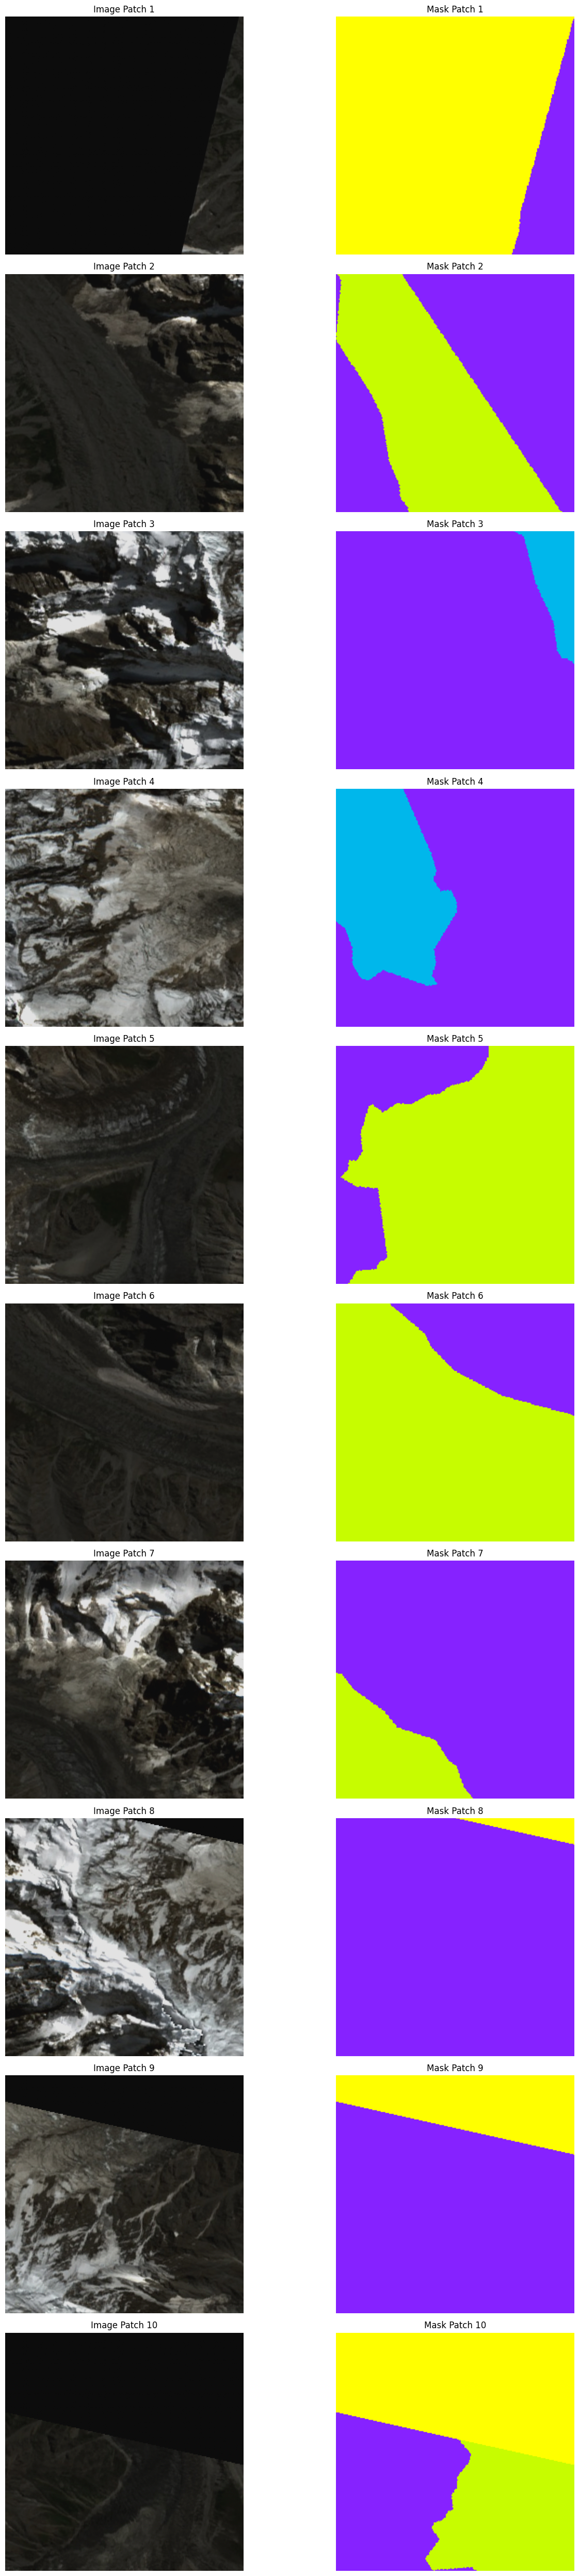

In [8]:
image_folder = '/content/drive/MyDrive/originals'  # Replace with your folder path
mask_folder = '/content/drive/MyDrive/masks'       # Replace with your folder path
patch_size = 256

image_patches, mask_patches = process_all_images(image_folder, mask_folder, patch_size)
visualize_patches(image_patches, mask_patches, color_map, num_samples=10)


**Step 2: Model Design & Training**

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU


In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Model

def decoder_block(input_tensor, skip_features, num_filters):
    """
    Decoder block for the U-Net model.

    Args:
        input_tensor: Input tensor to the decoder block.
        skip_features: Skip connection features from the encoder.
        num_filters: Number of filters for the convolutional layers.

    Returns:
        Output tensor of the decoder block.
    """
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    x = layers.Concatenate()([x, skip_features])
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    return x

def build_unet_vgg16(input_shape, num_classes):
    # Load VGG16 with pre-trained weights, excluding its top layers
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze VGG16 layers to retain pre-trained weights
    for layer in vgg16.layers:
        layer.trainable = False

    # Encoder blocks from VGG16
    s1 = vgg16.get_layer('block1_conv2').output  # Skip connection 1
    s2 = vgg16.get_layer('block2_conv2').output  # Skip connection 2
    s3 = vgg16.get_layer('block3_conv3').output  # Skip connection 3
    s4 = vgg16.get_layer('block4_conv3').output  # Skip connection 4
    p4 = vgg16.get_layer('block5_conv3').output  # Bridge

    # Decoder blocks
    d1 = decoder_block(p4, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(d4)

    return Model(inputs=vgg16.input, outputs=outputs)

# Model summary
input_shape = (256, 256, 3)
num_classes = 8
model = build_unet_vgg16(input_shape, num_classes)
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 256, 256, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 128, 128, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 128, 128, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 128, 128, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 64, 64, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 64, 64, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 32, 32, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 32, 32, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 16, 16, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 25,855,112 (98.63 MB)

 Trainable params: 11,140,424 (42.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy', MeanIoU(num_classes=num_classes)]
)


In [12]:
from sklearn.model_selection import train_test_split
import gc

# Ensure that the image data matches the expected input shape for VGG16
# VGG16 expects input shape of (256, 256, 3) for images
image_patches = image_patches.reshape(-1, 256, 256, 3)

# Ensure masks are in the right shape for output layer (num_classes = 8 in your case)
mask_patches = mask_patches.reshape(-1, 256, 256, 8)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(image_patches, mask_patches, test_size=0.2, random_state=42)

# Free up memory
gc.collect()


0

In [11]:
print(X_train.shape)  # Should output (num_train_samples, 256, 256, 3)
print(X_val.shape)  # Should output (num_val_samples, 256, 256, 3)


(964, 256, 256, 3)
(242, 256, 256, 3)


In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg16 import preprocess_input

# Apply VGG16-specific preprocessing
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

# Callbacks
# Change the file extension to '.keras'
checkpoint = ModelCheckpoint('unet_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

with tf.device('/GPU:0'):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=8,
        callbacks=[checkpoint, early_stopping]
    )


NameError: name 'X_train' is not defined

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3489791627469946480
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17154296276080090198
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
import tensorflow as tf  # Import TensorFlow and assign it the alias 'tf'

physical_devices = tf.config.experimental.list_physical_devices('GPU')
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1
